In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc

C:\Users\JAEKYU\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
def make_noise_vector(batch_size, noise_size):
    noise_vector = np.random.normal(size=(batch_size, noise_size))
    return noise_vector

In [3]:
class DCGAN(object):
    def __init__(self, sess, batch_size):
        self.sess = sess
        self.batch_size = batch_size
        self.input_channel = 1
        self.noise_size = 100
        self.input_width = 28
        self.input_height = 28
        self.parameter()
        self.model()
        #self.generator()
        #self.discriminator()
        
    def parameter(self):
        #input parameter
        self.X = tf.placeholder(dtype=tf.float32, shape=[None, self.input_width, self.input_height, self.input_channel])
        self.Z = tf.placeholder(dtype=tf.float32, shape=[None, self.noise_size])
                

    def generator(self, noise):
        with tf.variable_scope("generator_", reuse = tf.AUTO_REUSE):#tensorboard 추가
            noise = tf.convert_to_tensor(noise)
            noise = tf.layers.dense(inputs=noise, units = 7*7*1024, bias_initializer = tf.random_normal_initializer())
            noise = tf.reshape(noise, [-1, 7, 7, 1024])#7,7,1024
            noise = tf.layers.batch_normalization(inputs = noise)
            
            L1 = tf.layers.conv2d_transpose(noise, 256, [4, 4], strides=(2, 2), padding="SAME")#14,14,256
            #print(np.shape(L1))
            L1 = tf.layers.batch_normalization(inputs = L1)
            Y1 = tf.nn.relu(L1)

            L2 = tf.layers.conv2d_transpose(Y1, self.input_channel, [4, 4], strides=(2, 2), padding="SAME")#28,28,1
            #print(np.shape(L2))
            L2 = tf.layers.batch_normalization(inputs = L2)

            self.model_G= tf.nn.tanh(L2)
            
            return self.model_G
    
    def discriminator(self, input_data):
        with tf.variable_scope("discriminator_", reuse = tf.AUTO_REUSE):
            L1 = tf.layers.conv2d(input_data, 128, [5, 5], strides=(2, 2), padding="SAME")#28,28,1 -> 14,14,128
            #print(np.shape(L1))
            L1 = tf.layers.batch_normalization(inputs = L1)
            Y1 = tf.nn.leaky_relu(L1)

            L2 = tf.layers.conv2d(Y1, 256, [5, 5], strides=(2, 2), padding="SAME")#14,14,128 -> 7,7,256
            #print(np.shape(L2))
            L2 = tf.layers.batch_normalization(inputs = L2)
            Y2 = tf.nn.leaky_relu(L2)

            L3 = tf.layers.conv2d(Y2, 512, [5, 5], strides=(2, 2), padding="SAME")#7,7,256 -> 4,4,512
            #print(np.shape(L3))
            L3 = tf.layers.batch_normalization(inputs = L3)
            Y3 = tf.nn.leaky_relu(L3)

            L4 = tf.layers.conv2d(Y3, 1, [5, 5], strides=(2, 2), padding="SAME")#3,3,512 -> 2,2,1
            #print(np.shape(L4))
            L4 = tf.layers.batch_normalization(inputs = L4)
            Y4 = tf.nn.leaky_relu(L4)
            
            L5 = tf.layers.conv2d(Y4, 1, [5, 5], strides=(2, 2), padding="SAME")#2,2,1 -> 1,1,1
            #print(np.shape(L5))
            L5 = tf.layers.batch_normalization(inputs = L5)

            self.model_D = tf.nn.sigmoid(L5)
            #self.d_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'd')

            return self.model_D

    def model(self):
        with tf.name_scope("models") as scope:
            self.G = self.generator(self.Z)
            self.D_fake = self.discriminator(self.G)
            self.D_real = self.discriminator(self.X)
            
            self.cost_D = tf.reduce_mean(tf.log(self.D_real) + tf.log(1-self.D_fake))#maximize
            self.cost_G = tf.reduce_mean(tf.log(1-self.D_fake))#minimize
            
            self.t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
            
            self.d_vars = [var for var in self.t_vars if var.name.startswith("dis")]
            self.g_vars = [var for var in self.t_vars if var.name.startswith("gen")]
            
            self.Optimize_D = tf.train.AdamOptimizer(learning_rate=0.00002).minimize(-self.cost_D, \
                                                var_list = self.d_vars)
            self.Optimize_G = tf.train.AdamOptimizer(learning_rate=0.00002).minimize(self.cost_G, \
                                                var_list = self.g_vars)
            
            D_cost = tf.summary.scalar("d_cost", self.cost_D)#tensorboard 추가
            G_cost = tf.summary.scalar("g_cost", self.cost_G)#tensorboard 추가
            
            #D_opt = tf.summary.scalar("d_opt", self.Optimize_D)#tensorboard 추가
            #G_opt = tf.summary.scalar("g_opt", self.Optimize_G)#tensorboard 추가

    def training(self, is_training):
        merged_summary = tf.summary.merge_all()#tensorboard 추가
        writer = tf.summary.FileWriter("C:/Users/JAEKYU/Documents/log_simple_states")#tensorboard 추가
        writer.add_graph(self.sess.graph)#tensorboard 추가
        data_size = 55000
        total_batch = int(data_size / self.batch_size)
        SAVE_PATH = "C:/Users\JAEKYU/Documents/Jupyter Notebook/Deep Convolution Generative Adverserial Network/Weight/Weight.ckpt"   
        print("Session start")
        
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        if(not is_training):
            saver.restore(self.sess, SAVE_PATH)
            print("weight 값 load 끝~")
            noise_data = make_noise_vector(1, 100)
            predict = self.sess.run(self.G, feed_dict={self.Z : noise_data})#1, 28, 28, 1
            predict_0 = predict[0]#28, 28, 1
            predict_0 = predict_0.reshape(28, 28)
            print(np.shape(predict_0))
            #predict = predict[0].reshape(28, 28)
            plt.imshow(predict_0)
            plt.show()
            #print(np.shape(predict))

            decision = self.sess.run(self.D_fake, feed_dict={self.G : predict})
            print(decision)
            
            input_ = mnist.train.next_batch(batch_size=self.batch_size)[0]#32,784
            input_ = input_[0].reshape(-1, self.input_width, self.input_height, self.input_channel)
            decision2 = self.sess.run(self.D_real, feed_dict={self.X : input_})
            print(decision2)
            
        else:
            for epoch in range(70):
                #saver.restore(self.sess, SAVE_PATH)
                for i in range(total_batch):
                    #batch 만들기
                    batch_X = mnist.train.next_batch(batch_size=self.batch_size)[0]#32,784
                    batch_X = batch_X.reshape(-1, self.input_width, self.input_height, self.input_channel)
                    batch_Z = make_noise_vector(self.batch_size, self.noise_size)#-1,100
                    
                    Opt_G, cost_G = self.sess.run([self.Optimize_G, self.cost_G], feed_dict={self.Z : batch_Z})
                    Opt_D, cost_D, summary = self.sess.run([self.Optimize_D, self.cost_D, merged_summary], feed_dict={self.X : batch_X, self.Z : batch_Z})#tensorboard 추가
                    writer.add_summary(summary, global_step = epoch*total_batch + i)#tensorboard 추가
                print("epoch : ", epoch, ", gen_cost : ", cost_G, ", dis_cost : ", cost_D)
                saver.save(self.sess, SAVE_PATH)
                
                
                
                noise_data = make_noise_vector(self.batch_size, self.noise_size)#-1 x 100
                samples = 255*self.sess.run(self.G, feed_dict={self.Z : noise_data})
                samples = np.clip(samples, 0, 255).astype(np.uint8)
                buffer = samples[0].reshape(28,28)
                misc.imsave("./save/%d.jpg" %epoch, buffer)
                #print(buffer)
                fig, ax = plt.subplots(1, 1, figsize=(1, 1))
                ax.set_axis_off()
                ax.imshow(buffer)
                fig.show()
                plt.draw()
                plt.show()
                
    def testing(self):
        noise_data = make_noise_vector(self.batch_size, self.noise_size)#-1 x 100
        samples = self.sess.run(self.G, feed_dict={self.Z : noise_data})
        buffer = samples[0].reshape(28,28)
        print(np.shape(buffer))
        fig, ax = plt.subplots(1, 1, figsize=(1, 1))
        #for j in range(self.batch_size):
        ax.set_axis_off()
        ax.imshow(buffer)
        #fig.show()
        #plt.draw()
        #plt.show()
    
print("model")

model


Session start
INFO:tensorflow:Restoring parameters from C:/Users\JAEKYU/Documents/Jupyter Notebook/Deep Convolution Generative Adverserial Network/Weight/Weight.ckpt
weight 값 load 끝~
(28, 28)


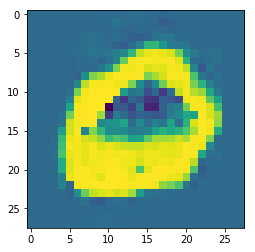

[[[[0.00046023]]]]
[[[[1.]]]]


In [4]:
with tf.Session() as sess:
    dcgan_object = DCGAN(sess=sess, batch_size=64)
    dcgan_object.training(False)#False load Weight/ True made Weight
    #dcgan_object.testing()
    

In [ ]:
#Data Load--------------------------------------------------------------------------------------
img_data = [None]


img_data = misc.imread("./save/6.jpg")
print(img_data)